In [1]:
# Importing relevant libraries

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from numpy import expand_dims, zeros, ones
from numpy.random import randn, randint
from keras.optimizers import RMSprop
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization 
from keras import backend
from keras.initializers import RandomNormal
from keras.constraints import Constraint

## Dataset

In [2]:
# data from: https://www.kaggle.com/abhijeetambekar/deep-learning-face-emotion
# code from: https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

#data = pd.read_csv('C:/Users/97254/Documents/Generative_Models/project/datasets/fer2013.csv')
data = pd.read_csv('./fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
num_classes = 7
img_width = 48
img_height = 48

In [5]:
data.shape

(35887, 3)

In [6]:
X = data['pixels']
y = data['emotion']

In [7]:
X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])

X_train = np.array(X_train)/255.0

In [8]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

In [9]:
X_train.shape

(35887, 48, 48, 1)

## Utils Functions

In [10]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

## Critic Model

In [11]:
# define the standalone critic model
def define_critic(in_shape=(48,48,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, 
                     input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

## Generator Model

In [12]:
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 12x12 image
	n_nodes = 128 * 12 * 12
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((12, 12, 128)))
	# upsample to 24x24
	model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 48x48
	model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 48x48x1
	model.add(Conv2D(1, (12,12), activation='tanh', padding='same', kernel_initializer=init))
	return model

In [13]:
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [14]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

In [15]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [16]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [18]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	#X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		plt.subplot(10, 10, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
    #plt.imshow(X[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [19]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	plt.plot(d1_hist, label='crit_real')
	plt.plot(d2_hist, label='crit_fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	plt.savefig('plot_line_plot_loss.png')
	plt.close()

In [24]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(np.mean(c1_tmp))
		c2_hist.append(np.mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

In [25]:
# size of the latent space
latent_dim = 100
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = X_train
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>6210, c1=-56631.588, c2=28393.550 g=-19003.178
>6211, c1=-57894.488, c2=15760.269 g=-8635.998
>6212, c1=-57367.468, c2=31719.380 g=-21771.350
>6213, c1=-62306.379, c2=14139.981 g=-8925.639
>6214, c1=-58682.066, c2=30331.321 g=-21341.611
>6215, c1=-61389.757, c2=14213.418 g=-9785.152
>6216, c1=-60774.439, c2=33275.552 g=-23858.768
>6217, c1=-61397.607, c2=19711.092 g=-13937.296
>6218, c1=-57867.479, c2=38039.764 g=-28138.121
>6219, c1=-59393.496, c2=16935.816 g=-11292.903
>6220, c1=-59070.287, c2=26743.537 g=-16369.248
>6221, c1=-59567.192, c2=23559.749 g=-17755.723
>6222, c1=-58032.494, c2=14536.071 g=-8983.562
>6223, c1=-59444.627, c2=36848.770 g=-28166.629
>6224, c1=-61675.482, c2=14557.253 g=-11848.857
>6225, c1=-63467.384, c2=23657.235 g=-18710.646
>6226, c1=-59165.773, c2=43816.016 g=-30882.361
>6227, c1=-63905.195, c2=10893.319 g=-8422.236
>6228, c1=-67595.822, c2=17243.818 g=-14232.201
>6229, c1=-62751.503, c2=41320.099 g=-2524

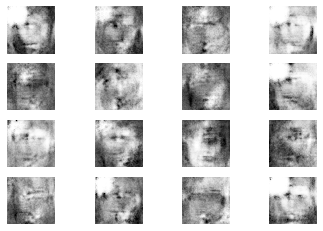

In [27]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('model_9520.h5')
# generate images
latent_points = generate_latent_points(100, 16)
# generate images
X = 255-model.predict(latent_points)                #switching black and white
# plot the result
show_plot(X, 4)